# Lecture 6 - Uncertainty Propagation using Sampling Methods: Variance Reduction Methods and Latin-hypercube designs

## Objectives

+ Learn about variance reduction methods
+ Learn about Latin-hypercube designs

## Readings

+ Monte Carlo Strategies in Scientific Computing (Jun S. Liu, 2001)

+ Monte Carlo Statistical Methods (Christian P. Robert and George Casella, 1999) 


## Variance reduction methods

First, we will discuss methods that may be used to reduce  the standard error of 
the sample mean approximation (or the integral). 
We will look into four different methods and we compare them
to mean Monte Carlo methods with examples. 

$$
\newcommand{\var}{{\rm var}}
\newcommand{\cov}{{\rm cov}}
\newcommand{\corr}{{\rm corr}}
$$

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## 1. Control Variates

The basic idea is to transform the function we would like to integrate into 
a different function where the variance of this new functions is much smaller
(or flatter).

Suppose again that we wish to estimate  $E[Y]$, where $Y = f(X)$ is the output of a simulation experiment.
Suppose the mean of a function $Z=g(X)$, $E[Z]=\tau$ is known or easily
estimated with a simulation. 
 
 The control variate method finds the best way to do so for 
 any arbitrary function $g(X)$. To do so we introduce a new function $f^{\star}$:
 
$$ f^{\star} (X) = f(X) + b[g(X)-\tau] $$

where $b$ is a constant. 


The expectation of this new function is identical to the original function, 

$$ E[ f^{\star}] =  E[ f] + b \, E[ g] - b \, \tau=  E[ f].  $$


Also the variance of the new function is 

$$
 \var(f^{\star}) = \var(f)+b^2 \,\var( g) +2 \,b\, \cov(f,g)  
$$


Since we are free to choose $b$, we should choose it to minimize $\var(f^{\star}) $. Simple calculus then implies that the
optimal value of $b$ is given by

$$ b_c = -\frac{\cov(f,g)}{\var(g)} $$

Substituting for $b_c$ above we see that

$$ \var(f^{\star}) = \var(f) - \frac{[\cov(f,g)]^2}{\var(g)}  = \var(f) (1-\rho^2(f,g)) $$

where $\rho(f,g)$ is the correlation coefficient of $f$ and $g$. 
This means that if $\rho^2$ is close to one, the variance of $f^{\star}$ becomes close
to zero. 
The function $g$ is called the control variate for $f$.


Now back to our integral. To use the control variate $g$ in our simulation we would like to modify our
algorithm so that after generating n samples of $f(X)$ and $g(X)$ we would simply set

 $$ I = \int_{V} f(x) dx \approx \frac{V}{N} \sum_i f^{\star}(x_i) =  \frac{V}{N} \sum_i \left[ f(x_i) +b_c (g(x_i) -\tau) \right] $$
 
 There is of course a problem with this.  We usually do not know $\cov(f,g)$. We overcome this problem by
approximating it from the samples. 

### Example

In this example we would like to estimate the integral of the function $f(x) = \cos(x) \exp(-x)+0.2  $ from 0 to 10. 

$$ I = \int_{0}^{10} dx [\cos(x) \exp(-x)+0.2] $$

and we introduce a control variate $g(x) =exp(-x)+0.2 $. This function is chosen such 
as the correlation of $f,g$ is close to one. [HOW DO I KNOW THIS?]

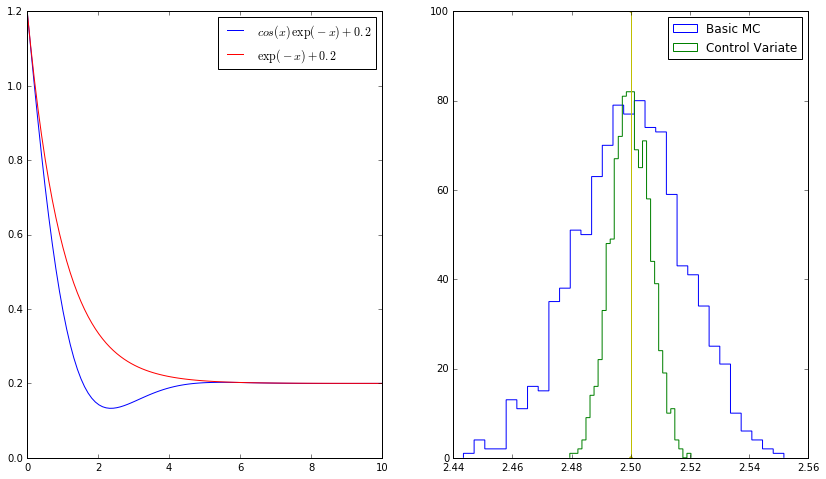

In [5]:
plt.figure(figsize=[14,8])
xmax = 10
xmin = 0
N=10000
f = lambda x: np.cos(x)*np.exp(-x)+0.2;
g = lambda x: np.exp(-x)+0.2;
fint= lambda z: z/5.0+ 0.5*np.exp(-z)*(np.sin(z)-np.cos(z))
fint_vr = lambda z:  z/5.0-np.exp(-z)
x = np.linspace(0,10, 100)
plt.subplot(1,2,1)
plt.plot(x, f(x), 'b', label=u'$cos(x)\, \exp(-x)+0.2$') 
plt.plot( x, g(x), 'r', label = u'$\exp(-x)+0.2$')
plt.legend()
Ivmc = np.zeros(1000)
Imc_vr = np.zeros(1000)
true_val = fint(xmax) - fint(xmin)
tau =(1.0/(xmax-xmin))*(fint_vr(xmax)-fint_vr(xmin));
for k in np.arange(0,1000):
    X = np.random.uniform( low=xmin, high=xmax, size=N)
    Ivmc[k] = (xmax-xmin)*np.mean(f(X));
    q = np.cov(g(X),f(X)); 
    b =- q[0,1]/np.var(g(X));
    Imc_vr[k] = (xmax-xmin)*(np.mean(f(X)) + b *(np.mean(g(X)) -tau));
yreal = true_val*np.ones(30);
plt.subplot(1,2,2)
plt.hist(Ivmc,30, histtype='step', label=u'Basic MC');
plt.hist(Imc_vr,30, histtype='step', label = u'Control Variate');
plt.plot([true_val, true_val], [0 ,100], 'y.-') 
plt.legend()

### Multiple Control Variates

Up until now we have only considered the possibility of using one control variate. However, there is no reason
why we should not use more than one and I will now describe how to do this. 
Suppose again that we wish to estimate    $E[Y]$ where $Y = f(X)$ is the output of a simulation experiment.
We also suppose that the means of the functions $E[Z_i]=\tau_i$ where $Z_i=g_i(X)$ for $i= 1\ldots m$ 
is known for each $i$.

We can then construct unbiased estimators of $E[Y]$ by setting 

$$  f^{\star}(X) = f(X)+b_1 \left[ g_1(X) - \tau_1\right] +b_2 \left[ g_2(X) - \tau_2\right] +\ldots +b_m \left[ g_m(X) - \tau_m\right] $$

To choose a good set of $b_i$'s, we compute $\var(f^{\star})$ and obtain

$$ \var(f^{\star}) = \var(f) +2 \, \sum_i^{m} b_i\, \cov(f,g_i) + \sum_{i}^{m} \sum_{j}^{m} b_i \, b_j \cov(g_i, g_j) $$


As before, we could use use calculus to find the optimal set of $b_i$'s 
by taking partial derivatives with respect to each $b_i$, 
set them equal to 0 and solve the resulting system of $m$ linear equations and $m$ unknowns. 
This is easy to do but as before, however, the optimal solutions $b_{i,c}$'s
will involve unknown quantities so that they will need to be
estimated using the samples. A convenient way of estimating the $b_{i,c}$'s
is to observe that $b_{i,c}=-c_i$'s, where $c_i$'s are the solution to the linear regression 

$$ Y = a + c_1 g_1(X) + \ldots + c_m g_m(X) + \epsilon $$

where  $\epsilon $ is an error term. 


## 2. Antithetic Variates

Suppose as usual that we would like to estimate $E[f(X)] = E[Y ]$, 
and that we have generated two samples,
$Y_1=f(X_1)$ and $Y_2=f(X_2)$. Then the expectation of

$$ Z = \frac{1}{2} \left[  Y_1 + Y_2 \right] $$

$E[Z] = E[Y]$

and 

$$ \var(Z) = \frac{ \var(Y_1)+\var(Y_2) + 2 \cov(Y_1,Y_2)}{4}. $$


Therefore, the more negatively correlated $Y_1=f(X_1)$ is with $Y_2=f(X_2)$, the more the variance will be reduced.
If $Y_1$ and $Y_2$ are iid, then the $\var(Z) = \var(Y_1)/2=\var(Y_2)/2$.
On the other hand, we could reduce $\var(Z)$ if we could make it so that
$\cov(Y_1, Y_2) < 0$. 

Lets try it out. Generate two samples that are correlated 

In [8]:
Y1= np.random.uniform(low=0, high=1, size=10000)
Y2a= np.random.uniform(low=0, high=1, size=10000)
rho =-0.9
Y2 = Y1*rho + np.sqrt(1-rho**2) * Y2a
Z= 0.5*(Y1+Y2)
print np.var(Z), np.var(Y1), np.var(Y2), np.cov(Y1,Y2)

0.00414669839515 0.082423094319 0.0832578345725 [[ 0.08243134 -0.07455452]
 [-0.07455452  0.08326616]]


The method of antithetic variates describes how to do this idea in reducing the estimator error of an integral. 
Suppose $X \sim U(0, 1)$ iid random variables and

$$ \theta=E[f(X)]=E[f(U)] $$

If we construct two samples $U$ and $1-U$, each of length $n$ and now define
$$ Y_1 = f(U)  \hspace{2cm} Y_2 = f(1-U) $$

then the expectation of 
$$Z = \frac{1}{2} \left[  Y_1 + Y_2 \right] $$
$E[Z] = E[Y]$ as before. 


If we compare this with the mean MC with  $2n$ sample, the question
remains as to which algorithm is better. 
Note that both algorithms require approximately the same amount of time. 
That is, comparing the two algorithms amounts to computing which estimator has a smaller variance.

Say we want to calculate 

$$ I = \int f(X) dX $$

and let $X\sim U(0,1)$ for $2n$ samples and $Y=f(X)$, 

$$ \var(\hat{I}_{2n}) = \frac{\var(Y)}{2n} $$ 


on the other hand 

$$ \var(\hat{I}_{n+n})  = \frac{\var(Z)}{n}  = \frac{\var(Y_1+Y_2)}{4n} = \frac{\var(Y_1)}{2n}+\frac{\cov(Y_1,Y_2)}{2n} $$

So again to reduce the $\hat{I}_{n+n}$, we would like to make the $\cov(Y_1,Y_2)$ as negative 
as possible. 

If the $Y$'s are monotonic functions of $X$ then this guarantees if $Y_1 = f(X)$ and $Y_2=f(1-X)$ then
$Y_1,Y_2$  are negatively correlated.

### Example

In this example we are trying to calculate  the integral of $f(x) = 1/(x+1)$ from $[0,1]$. To do so 
 we generate $X_1=U$ from a uniform distribution and $X_2=1-U$. Because $X_1,X_2$ are correlated,
 one can show that $Y_1=f(X_1),Y_2=f(X_2)$ are also strongly correlated if the function is monotonic.
 [PROOF]
 

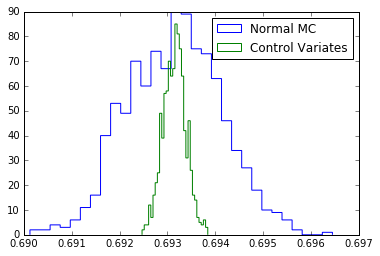

In [10]:
N =10000
xmin = 0 
xmax = 1
Y = lambda x:  1/(x+1)
intY = lambda x: np.log(x+1) 
Iact = intY(xmax)-intY(xmin)
Ivmc=np.zeros(1000)
Iant=np.zeros(1000)
# GENERATING THE SAMPLE X1, X2 iid and X1 amd Y1 negatively correlated 
for k in np.arange(0,1000):
    U = np.random.uniform(low=0, high=1, size=2*N)
    X=U
    # VANILLA MC
    Ivmc[k] =  np.mean(Y(X))
    # ANTITHETIC MC
    U = np.random.uniform(low=0, high=1, size=N) 
    X1= U
    X2= 1-U
    Iant[k] = 0.5*( np.mean(Y(X1))+np.mean(Y(X2)))
plt.hist(Ivmc,30, histtype='step', label=u'Normal MC')
plt.hist(Iant,30,  histtype='step', label=u'Control Variates')
plt.legend()

## 3. Stratified Method

The key idea is to achieve a more regular sampling of the
most `important' dimension in the uncertainty.
Start by considering a one-dimensional problem:

$$ I= \int_{0}^{1} f(x) \, dx $$

and lets assume $x$ is drawn from a uniform distribution. 

$$ I= \int_{0}^{1} f(U) \, dU $$


Instead of taking $N$ samples, drawn from uniform
distribution, we break the interval into $M$ _strata_ of equal width and take $L$ samples for each
strate, $N=LM$.

Let $U_{ij}$ be the value of the $i$-th sample and strata $j$. The average from strata $j$ is

$$ 
I_j = E[f(U_j)]\approx  \frac{1}{L} \sum_i f(U_{ij}) 
$$

and the overall integral without stratification is:

$$ 
I =E[f(U)] \approx \frac{1}{N}\sum_{i,j}  f(U_{ij}) 
$$

With stratification we would average the estimations in each strata
$$
 I_s \approx \frac{1}{M} \sum_j I_j 
$$


and that is obviously the same as the estimation without stratification.
When we take strata we average the estimate for each strata as

$$
I_s = \frac{1}{M} \sum_j I_j =  \frac{1}{M} \sum_j \frac{1}{L} \sum_{i}  f(U_{ij})=  \frac{1}{N} \sum_{i,j}  f(U_{ij})= I
$$

To do the analysis of the variance, lets remind ourselves that the 
MC estimated variance is  $\sigma_I=\frac{\var(f)}{N}$. The variance without stratification is then 

$$
\var(I) = \frac{\var(f)}{N} = \frac{E[f^2] - E[f]^2}{N}  = \frac{E[f^2] - I^2}{N}
$$


The expectation of $f^2$ can be expanded as 

$$
E[f^2] \approx \frac{1}{N} \sum_{ij} f^2(U_{ij}) =\frac{1}{N} \sum_j L \left[ \frac{1}{L} \sum_i f^2(U_{ij}) \right]=\frac{L}{N}  \sum_j E[f^2(U_j)] = \frac{1}{M}  \sum_j E[f^2(U_j)] 
$$

however from the definition of $\sigma_j^2$ 

$$
\sigma_j^2 = E[ f^2(U_j)] - E[f(U_j)]^2 = E[ f^2(U_j)] - I_j^2  
$$

$$
 \Rightarrow E[ f^2(U_j)] =\sigma_j^2 + I_j^2   
$$


substituting this, we get

$$
\var(I) =\frac{ \frac{1}{M}  \sum_j  (\sigma_j^2 + I_j^2)- I^2}{N} = \frac{1}{NM}\sum_j  \sigma_j^2 + \frac{1}{N} \left( \frac{\sum_j  I_j^2}{M} -  I^2 \right)
$$

the variance with stratification is 

$$
\var(I_s)= \var\left(  \frac{1}{M} \sum_j I_j  \right)  = \frac{1}{M^2}  \var\left(\sum_j I_j  \right)  = \frac{1}{M^2}  \sum_j \var(I_j)
 = \frac{1}{M^2}   \sum_j  \frac{\sigma_j^2}{L} =  \frac{1}{M^2 \,L}   \sum_j  \sigma_j^2 
$$
 
where we ignore all covariances since the deviations about $I_j$ are all iid and uncorrelated.


Finally, 
$$
  \var(I_s)= \frac{1}{M^2} \frac{ 1}{L}   \sum_j \sigma_j^2  =  \frac{1}{MN}  \sum_j \sigma_j^2 \le \var(I)
$$

where the last step is based on the fact that 
$$  \frac{\sum_j  I_j^2}{M} -  I^2  > 0 $$
by the Cauchy-Schwarz Inequality.

Thus stratified sampling reduces the variance.


Sub-dividing into strata always reduces the variance, so the optimum choice is to use 1 sample per
stratum. 
However, we need multiple samples in each stratum to
estimate the variance and obtain a confidence interval.
Despite this, interesting to analyze what happens with
1 sample per stratum.

### Example

For a  one-dimensional application we take $ x/(x^2+1)$ and integrate from $[0,1]$.
We break $[0,10]$ into $M$ strata and for each stratum, take $N/M$ samples
with uniform probability distribution. Compute the average within each 
stratum, and then calculate the overall average. 

C:\Users\Guang\Anaconda2\lib\site-packages\ipykernel\__main__.py:29: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


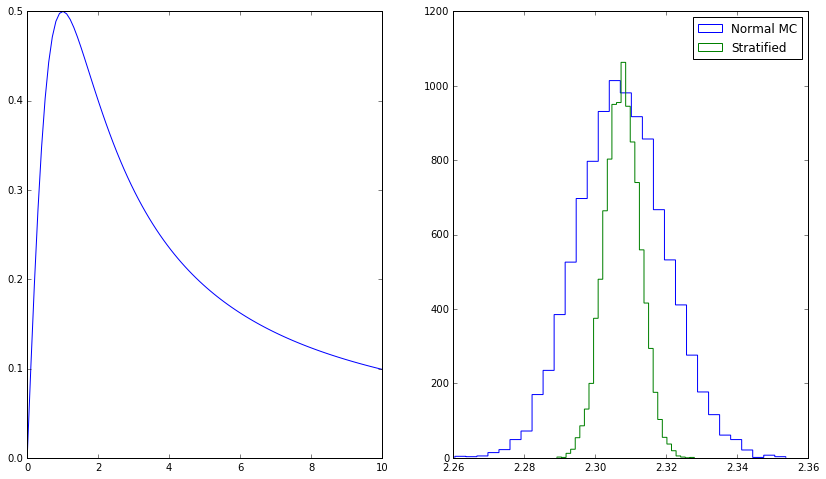

In [12]:
plt.figure(figsize=[14,8])
Y = lambda x: x/(x**2+1.0);
intY = lambda x: np.log(x**2 + 1.0)/2.0;
## Ploting the original functions 
plt.subplot(1,2,1)
x = np.linspace(0,10,100)
plt.plot(x, Y(x), label=u'$x/(x**2+1)$')
N= 10000
M = 10   # number of strate 
xmin=0
xmax =10
# analytic solution 
Ic = intY(xmax)-intY(xmin)
Imc = np.zeros(N)
Is = np.zeros(N)
Ns = 10
for k in np.arange(0,N):
    Umin=0
    Umax =10
    # First lets do it with mean MC method 
    U = np.random.uniform(low=Umin, high=Umax, size=N)
    Imc[k] = (Umax-Umin)* np.mean(Y(U))
    #stratisfied it in Ns regions
    step = (Umax-Umin )/M
    Umin = 0 
    Umax = step
    Ii = 0
    for reg in np.arange(0,M):
        x = np.random.uniform(low=Umin, high=Umax, size=1.0*N/Ns);
        Ii = Ii+(Umax-Umin)* np.mean(Y(x))
        Umin = Umin + step
        Umax = Umin + step
    Is[k] = Ii
plt.subplot(1,2,2)
plt.hist(Imc,30, histtype='step', label=u'Normal MC')
plt.hist(Is, 30, histtype='step', label=u'Stratified')
plt.legend()

## Latin-Hypercube Designs

Second, we will discuss Latin-hypercube designs. 
Latin hypercube sampling (LHS) is a statistical method for generating a sample of plausible collections 
of parameter values from a multidimensional distribution. The sampling method is often used to construct computer experiments. 

In the context of statistical sampling, a square grid containing sample positions is a Latin square
if (and only if) there is only one sample in each row and each column.
A Latin hypercube is the generalisation of this concept to an arbitrary number of dimensions, whereby each sample is the only one 
in each axis-aligned hyperplane containing it.


When sampling a function of $N$ variables, the range of each variable is divided into M equally probable intervals.
M sample points are then placed to satisfy the Latin hypercube requirements; note that this forces the number of divisions, M,
to be equal for each variable. Also note that this sampling scheme does not require more samples for more dimensions (variables);
this independence is one of the main advantages of this sampling scheme. Another advantage is that random samples can be taken one at a time,
remembering which samples were taken so far. 
The maximum number of combinations for a Latin Hypercube of M divisions and N variables (i.e., dimensions) can be computed with the following formula:
$(M!)^{N-1}$
For example, a Latin hypercube of M = 4 divisions with N = 2 variables (i.e., a square) will have 24 possible combinations.
A Latin hypercube of M = 4 divisions with N = 3 variables (i.e., a cube) will have 576 possible combinations.


In two dimensions the difference between random sampling, and Latin Hypercube sampling can be explained as follows:
In random sampling new sample points are generated without taking into account the previously generated sample points.
One does not necessarily need to know beforehand how many sample points are needed.
In Latin Hypercube sampling one must first decide how many sample points to use and for each sample point remember
in which row and column the sample point was taken.


References 
 + McKay, M.D.; Beckman, R.J.; Conover, W.J. (May 1979). A Comparison of Three Methods for Selecting Values of Input
Variables in the Analysis of Output from a Computer Code. Technometrics (JSTOR Abstract) (American Statistical Association)
21 (2): 239–245. doi:10.2307/1268522. ISSN 0040-1706. JSTOR 1268522. OSTI 5236110.
+ Eglajs, V.; Audze P. (1977). New approach to the design of multifactor experiments. Problems of Dynamics and Strengths.
35 (in Russian) (Riga: Zinatne Publishing House): 104–107.
+ Iman, R.L.; Helton, J.C.; Campbell, J.E. (1981). An approach to sensitivity analysis of computer models, Part 1. Introduction,
input variable selection and preliminary variable assessment. Journal of Quality Technology 13 (3): 174–183.
+ Iman, R.L.; Davenport, J.M.; Zeigler, D.K. (1980). Latin hypercube sampling (program user's guide). OSTI 5571631.


[[ 0.9  0.5]
 [ 0.1  0.1]
 [ 0.7  0.7]
 [ 0.5  0.3]
 [ 0.3  0.9]]


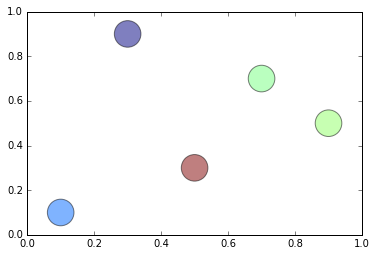

In [23]:
## Random Latin Hypercube
import design 
X=design.latin_center(5,2) 
colors = np.random.rand(5) 
area = np.pi * (15)**2  # 0 to 15 point radiuses 
print X
plt.scatter(X[:,0], X[:,1], area, colors, alpha=0.5) 
plt.show() 

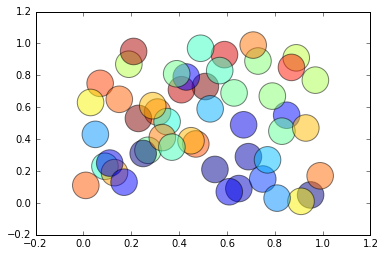

In [25]:
X=design.latin_center(50,2) 
colors = np.random.rand(50) 
area = np.pi * (15)**2  # 0 to 15 point radiuses 
plt.scatter(X[:,0], X[:,1], area, colors, alpha=0.5) 
plt.show() 

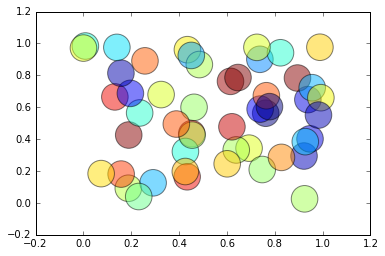

In [27]:
import scipy.stats as st
X=st.uniform(0, 1)
colors = np.random.rand(50) 
area = np.pi * (15)**2  # 0 to 15 point radiuses 
plt.scatter(X.rvs(50), X.rvs(50), area, colors, alpha=0.5) 
plt.show() 

## MC vs Latin Hyper-cubes
Consider the ODE:
  \begin{align*}
    \dot{y} = \frac{d y(t)}{dt} & =-ay(t),\qquad y(0) = I.
  \end{align*}
The solution is: $y(t) = Ie^{-at}$.
Let's make $a$ and $I$ random and use MC and LHS to find the mean, $E[y(t)]$, and the variance $V[y(t)]$.
We'll take:
$$
a \sim \text{Uniform}(0, 0.1),
$$
and
$$
I \sim \text{Uniform}(8, 10).
$$

For convenience, let's map these random variables to standardized uniform random variables:
$$
x_i \sim \text{Uniform}(0, 1), i=1,2.
$$
This can be done by defining:
$$
a = 0.1 x_1, I = 8 + 2 x_2.
$$
Using the new random variables, the ODE can be written as:
$$
\dot{y} = -0.1 x_1 y, y(0) = 8 + 2x_2.
$$

### The "Solver" object
Let's develop a solver for this problem. We'll make the solver work as a nice function that accepts a vector $\mathbf{x} = (x_1, x_2)$ as an input, and returns the solution of the ODE on a finite set of timesteps $0=t_1<t_2<\dots<t_{n_t}=T$. The solver, will make use of the functionality of [scipy.integrate.odeint](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.odeint.html). This is a trivial problem, but studying its structure will teach you a few useful Python tricks.

In [34]:
import scipy.integrate
import numpy as np

class Ex1Solver(object):
    """
    An object that can solver the afforementioned ODE problem.
    It will work just like a multivariate function.
    """
    
    def __init__(self, nt=100, T=5):
        """
        This is the initializer of the class.
        
        Arguments:
            nt - The number of timesteps.
            T  - The final time.
        """
        self.nt = nt
        self.T = T
        self.t = np.linspace(0, T, nt) # The timesteps on which we will get the solution
        # The following are not essential, but they are convenient
        self.num_input = 2             # The number of inputs the class accepts
        self.num_output = nt           # The number of outputs the class returns
    
    def __call__(self, x):
        """
        This special class method emulates a function call.
        
        Arguments:
            x - A 1D numpy array with 2 elements. This represents the stochastic input x = (x1, x2).
        """
        def rhs(y, t, x1):
            """
            This is the right hand side of the ODE.
            """
            return -.1 * x1 * y
        # The initial condition
        y0 = [8 + 2 * x[1]]
        # We are ready to solve the ODE
        y = scipy.integrate.odeint(rhs, y0, self.t, args=(x[0],)).flatten()
        # The only strange thing here is the use of ``args`` to pass they x1 argument to the rhs().
        # That's it
        return y

Since this is the first time we see a Python class, let's play with it.

In [17]:
# Here is how you can initialize it:
solver = Ex1Solver()
# You can access its arguments:
print "Number of timesteps:", solver.nt
print "Final time:", solver.T
print "Timesteps:", solver.t
print "Num inputs:", solver.num_input
print "Num outputs:", solver.num_output

Number of timesteps: 100
Final time: 5
Timesteps: [ 0.          0.05050505  0.1010101   0.15151515  0.2020202   0.25252525
  0.3030303   0.35353535  0.4040404   0.45454545  0.50505051  0.55555556
  0.60606061  0.65656566  0.70707071  0.75757576  0.80808081  0.85858586
  0.90909091  0.95959596  1.01010101  1.06060606  1.11111111  1.16161616
  1.21212121  1.26262626  1.31313131  1.36363636  1.41414141  1.46464646
  1.51515152  1.56565657  1.61616162  1.66666667  1.71717172  1.76767677
  1.81818182  1.86868687  1.91919192  1.96969697  2.02020202  2.07070707
  2.12121212  2.17171717  2.22222222  2.27272727  2.32323232  2.37373737
  2.42424242  2.47474747  2.52525253  2.57575758  2.62626263  2.67676768
  2.72727273  2.77777778  2.82828283  2.87878788  2.92929293  2.97979798
  3.03030303  3.08080808  3.13131313  3.18181818  3.23232323  3.28282828
  3.33333333  3.38383838  3.43434343  3.48484848  3.53535354  3.58585859
  3.63636364  3.68686869  3.73737374  3.78787879  3.83838384  3.88888889
 

In [35]:
# If you wish, you may intiialize it with a different initial arguments:
solver = Ex1Solver(nt=200, T=50)
print "Number of timesteps:", solver.nt
print "Final time:", solver.T
print "Timesteps:", solver.t
print "Num inputs:", solver.num_input
print "Num outputs:", solver.num_output

Number of timesteps: 200
Final time: 50
Timesteps: [  0.           0.25125628   0.50251256   0.75376884   1.00502513
   1.25628141   1.50753769   1.75879397   2.01005025   2.26130653
   2.51256281   2.7638191    3.01507538   3.26633166   3.51758794
   3.76884422   4.0201005    4.27135678   4.52261307   4.77386935
   5.02512563   5.27638191   5.52763819   5.77889447   6.03015075
   6.28140704   6.53266332   6.7839196    7.03517588   7.28643216
   7.53768844   7.78894472   8.04020101   8.29145729   8.54271357
   8.79396985   9.04522613   9.29648241   9.54773869   9.79899497
  10.05025126  10.30150754  10.55276382  10.8040201   11.05527638
  11.30653266  11.55778894  11.80904523  12.06030151  12.31155779
  12.56281407  12.81407035  13.06532663  13.31658291  13.5678392
  13.81909548  14.07035176  14.32160804  14.57286432  14.8241206
  15.07537688  15.32663317  15.57788945  15.82914573  16.08040201
  16.33165829  16.58291457  16.83417085  17.08542714  17.33668342
  17.5879397   17.83919598 

In [36]:
# Now let's evaluate the solver at a specific input.
# You can just use it as a function
x = [0.5, 0.5]
y = solver(x)
print y.shape

(200,)


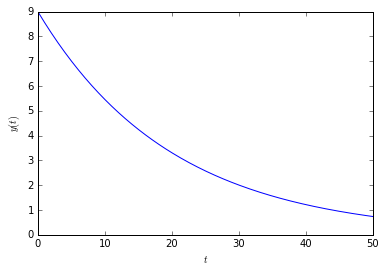

In [37]:
# Let's plot it:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(solver.t, y)
plt.xlabel('$t$')
plt.ylabel('$y(t)$')

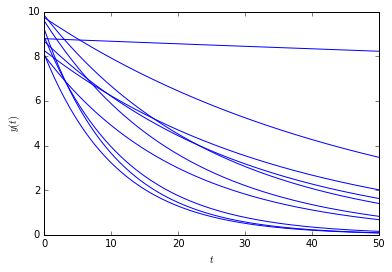

In [38]:
# Now, let's just plot a few random samples.
for i in xrange(10):
    x = np.random.rand(2)
    y = solver(x)
    plt.plot(solver.t, y, 'b')
plt.xlabel('$t$')
plt.ylabel('$y(t)$')

### Propagating Uncertainties with MC

Let's propagate the uncertainties through the ODE using MC.

In [106]:
# Let's now do Monte Carlo to compute the mean and the variance
# This is to accumulate the sum of all outputs
y_mc = np.zeros(solver.num_output)
# This is to accumlate the square of all outputs
y2_mc = np.zeros(solver.num_output)
# Pick the number of samples you wish to do:
num_samples = 10000
# Let's do it
for i in xrange(num_samples):
    if i % 1000 == 0:
        print 'sample', i + 1, 'from', num_samples
    x = np.random.rand(2)
    y = solver(x)
    y_mc += y
    y2_mc += y ** 2
# Now we are ready for the mean estimate:
y_m_mc = y_mc / num_samples
# And the variance estimate
y_v_mc = y2_mc / num_samples - y_m_mc ** 2

sample 1 from 10000
sample 1001 from 10000
sample 2001 from 10000
sample 3001 from 10000
sample 4001 from 10000
sample 5001 from 10000
sample 6001 from 10000
sample 7001 from 10000
sample 8001 from 10000
sample 9001 from 10000


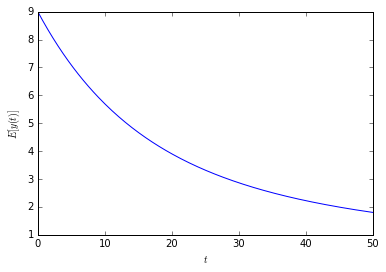

In [41]:
# Let's plot the mean
plt.plot(solver.t, y_m_mc)
plt.xlabel('$t$')
plt.ylabel('$E[y(t)]$')

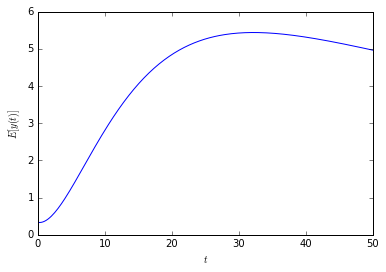

In [42]:
# Let's plot the variance
plt.plot(solver.t, y_v_mc)
plt.xlabel('$t$')
plt.ylabel('$E[y(t)]$')

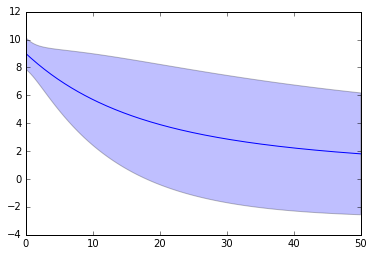

In [44]:
# Now, let's draw the predictive envelop
# We need the standard deviation:
y_s_mc = np.sqrt(y_v_mc)
# A lower bound for the prediction
y_l_mc = y_m_mc - 1.96 * y_s_mc
# An upper bound for the prediction
y_u_mc = y_m_mc + 1.96 * y_s_mc
# And let's plot it:
plt.plot(solver.t, y_m_mc)
plt.fill_between(solver.t, y_l_mc, y_u_mc, alpha=0.25)

### Propagating Uncertainties with LHS

Let's propagate the uncertainties through the ODE using LHS.
All we have to do is to copy and paste the above code and make some modifications.

In [52]:
import design
# Let's now do LHS to compute the mean and the variance
# This is to accumulate the sum of all outputs
y_lhs = np.zeros(solver.num_output)
# This is to accumlate the square of all outputs
y2_lhs = np.zeros(solver.num_output)
# Pick the number of samples you wish to do:
num_samples = 10000
# You have to create the LHS design prior to looping:
X = design.latin_center(num_samples, 2)
# Let's do it
for i in xrange(num_samples):
    if i % 1000 == 0:
        print 'sample', i + 1, 'from', num_samples
    x = X[i, :]
    y = solver(x)
    y_lhs += y
    y2_lhs += y ** 2
# Now we are ready for the mean estimate:
y_m_lhs = y_lhs / num_samples
# And the variance estimate
y_v_lhs = y2_lhs / num_samples - y_m_lhs ** 2

sample 1 from 10000
sample 1001 from 10000
sample 2001 from 10000
sample 3001 from 10000
sample 4001 from 10000
sample 5001 from 10000
sample 6001 from 10000
sample 7001 from 10000
sample 8001 from 10000
sample 9001 from 10000


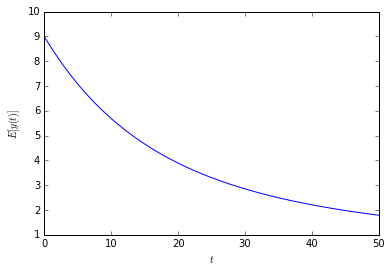

In [53]:
# Let's plot the mean
plt.plot(solver.t, y_m_lhs)
plt.xlabel('$t$')
plt.ylabel('$E[y(t)]$')

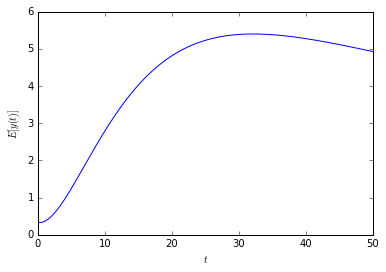

In [54]:
# Let's plot the variance
plt.plot(solver.t, y_v_lhs)
plt.xlabel('$t$')
plt.ylabel('$E[y(t)]$')

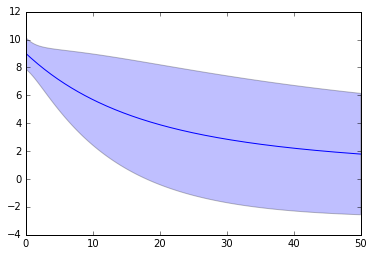

In [55]:
# Now, let's draw the predictive envelop
# We need the standard deviation:
y_s_lhs = np.sqrt(y_v_lhs)
# A lower bound for the prediction
y_l_lhs = y_m_lhs - 1.96 * y_s_lhs
# An upper bound for the prediction
y_u_lhs = y_m_lhs + 1.96 * y_s_lhs
# And let's plot it:
plt.plot(solver.t, y_m_lhs)
plt.fill_between(solver.t, y_l_lhs, y_u_lhs, alpha=0.25)

## Comparing MC to LHS

So, which one is better? MC or LHS? To test this, we need to establish a ground truth.
Fortunately, we can get an analytic solution to:
$$
\dot{y} = -0.1 x_1 y, y(0) = 8 + 2x_2.
$$
It is:
$$
y(t;x_1,x_2) = (8 + 2x_2)e^{-0.1 x_1 t}.
$$
We can integrate $x_1$ and $x_2$ analytically from this experssion.

In [90]:
import sympy
from sympy.utilities.autowrap import ufuncify
sympy.init_printing()
x1 = sympy.Symbol('x1')
x2 = sympy.Symbol('x2')
t = sympy.Symbol('t')
y = (8 + 2 * x2) * sympy.exp(-0.1 * x1 * t)
y

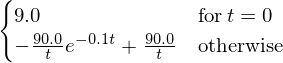

In [91]:
# Computing the expectation
E_y = sympy.integrate(y, (x2, 0, 1), (x1, 0, 1))
fE_y = ufuncify([t], E_y)
E_y

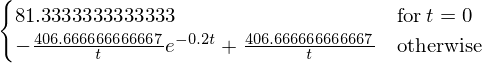

In [95]:
E_y2 = sympy.integrate(y ** 2, (x2, 0, 1), (x1, 0, 1))
E_y2

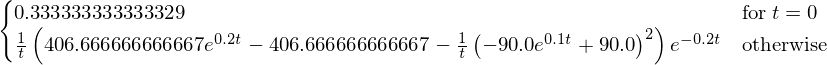

In [97]:
V_y = sympy.simplify(E_y2 - E_y ** 2)
fV_y = ufuncify([t], V_y)
V_y

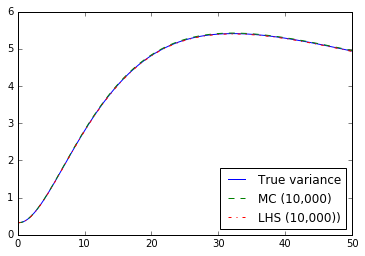

In [107]:
# Let's start by doing some plots that compare the variance obtained by MC and LHS to the true one
plt.plot(solver.t, fV_y(solver.t), label='True variance')
plt.plot(solver.t, y_v_mc, '--', label='MC (10,000)')
plt.plot(solver.t, y_v_lhs, '-.', label='LHS (10,000))')
plt.legend(loc='best')

They seem close. But this is for 10,000 samples.
Let's test the convergence of each method. To do this, we will compute the evolution of the root square error in the variance:
$$
\mbox{RSE}_\alpha(n) = \left(\sum_{i=1}^{n_t}\left(V[y(t_i)] - V_{\alpha,n}[y(t_i)]\right)^2\right)^{\frac{1}{2}},
$$
where $\alpha = \{\mbox{MC}, \mbox{LHS}\}$ stands for the method, $n$ for the number of samples used, and $V_{\alpha,n}[y(t_i)]$ for the estimate of the variance of $y(t_i)$.
It will probably take a while to develop the code.

In [183]:
def get_MC_rse(max_num_samples=100):
    """
    Get the maximum error of MC.
    """
    y_v_true = fV_y(solver.t)
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    n = []
    rse = []
    for i in xrange(max_num_samples):
        x = np.random.rand(2)
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        if i % 1 == 0:    # Produce estimate every 100 steps
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))
    return n, rse


In [183]:
def _get_LHS_rse(max_num_samples=100):
    y_v_true = fV_y(solver.t)
    y = np.zeros(solver.num_output)
    y2 = np.zeros(solver.num_output)
    n = []
    rse = []
    X = design.latin_center(max_num_samples, 2)
    for i in xrange(max_num_samples):
        x = X[i, :]
        y_sample = solver(x)
        y += y_sample
        y2 += y_sample ** 2
        if i % 1 == 0:    # Produce estimate every 100 steps
            n.append(i + 1)
            y_m = y / (i + 1)
            y_v = y2 / (i + 1) - y_m ** 2
            rse.append(np.linalg.norm(y_v_true - y_v))
    return n, rse


In [183]:
def get_LHS_rse(max_num_samples=100):
    n = []
    rse = []
    for i in xrange(max_num_samples):
        if i % 1 == 0:
            _n, _rse = _get_LHS_rse(i + 1)
            n.append(_n[-1])
            rse.append(_rse[-1])
    return n, rse

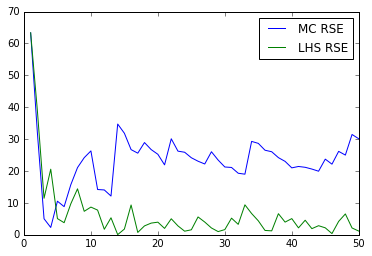

In [184]:
n_mc, rse_mc = get_MC_rse(50)
n_lhs, rse_lhs = get_LHS_rse(50)
plt.plot(n_mc, rse_mc, label='MC RSE')
plt.plot(n_lhs, rse_lhs, label='LHS RSE')
plt.legend(loc='best')

It is hard to tell which one is better...
There is a considerable ammount of epistemic uncertainty.
How would you go about quantifying it?
Notice, that everytime you run the above code, it produces a different estimate. This suggests, that if you repeat the procedure, say 100 times, you will be able to get predictive error bars for the error!

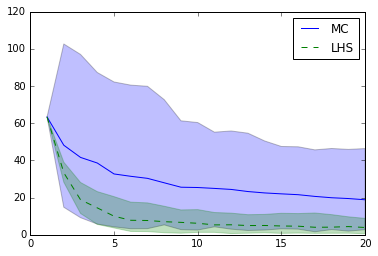

In [188]:
num_exper = 100
num_samples = 20
rse_mc_samples = []
rse_lhs_samples = []
for i in xrange(num_exper):
    n_mc, rse_mc = get_MC_rse(num_samples)
    n_lhs, rse_lhs = get_LHS_rse(num_samples)
    rse_mc_samples.append(rse_mc)
    rse_lhs_samples.append(rse_lhs)
rse_mc_samples = np.array(rse_mc_samples)
rse_lhs_samples = np.array(rse_lhs_samples)
rse_mc_m = np.mean(rse_mc_samples, axis=0)
rse_mc_l = np.percentile(rse_mc_samples, 2.75, axis=0)
rse_mc_u = np.percentile(rse_mc_samples, 97.5, axis=0)
rse_lhs_m = np.mean(rse_lhs_samples, axis=0)
rse_lhs_l = np.percentile(rse_lhs_samples, 2.75, axis=0)
rse_lhs_u = np.percentile(rse_lhs_samples, 97.5, axis=0)
plt.plot(n_mc, rse_mc_m, label='MC')
plt.plot(n_lhs, rse_lhs_m, '--', label='LHS')
plt.fill_between(n_mc, rse_mc_l, rse_mc_u, alpha=0.25)
plt.fill_between(n_lhs, rse_lhs_l, rse_lhs_u, color='g', alpha=0.25)
plt.legend(loc='best')
plt.xlabel

Now, it is obvious to tell which one is better.